In [2]:
from collections import Counter
import os
import pandas as pd
from qiime2 import Artifact
from qiime2.metadata import Metadata
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
from qiime2.plugins.feature_table.methods import filter_samples, filter_seqs, relative_frequency
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.taxa.visualizers import barplot
from qiime2 import Visualization
from scipy import stats
import seaborn as sns
import tempfile

%matplotlib inline

In [3]:
working_dir = os.path.abspath('../')
refs_dir = working_dir + '/taxonomy_references'
references = ['silva', 'silva_extended', 'gg', 'gg_extended']

In [4]:
studies = ['GCMP', 'GSMP']
denoisers = ['dada2', 'deblur']
classifiers = ['vsearch', 'nb']

In [55]:
for study in studies:
    df = pd.read_csv(working_dir + '/input/' + study + '.txt', '\t', dtype = str)
    ids_df = df[['#SampleID']]
    ids_index = ids_df.set_index('#SampleID')
    ids = Metadata(ids_index)
    for denoiser in denoisers:
        ft = Artifact.load(working_dir + '/output/' + study + '_' + denoiser + '_ft.qza')
        for reference in references:
            for classifier in classifiers:
                taxonomy = Artifact.load(working_dir + '/output/' + study  + denoiser + '_' + reference + '_' + classifier + '_classifications.qza')
                tbp, = barplot(ft, taxonomy, ids)
                tbp.save(working_dir + '/' + study + '/output/' + denoiser + '_' + reference + '_' + classifier + '_tbp.qzv')

In [9]:
#this is the cell within which to capture absolute numbers if we want to calculate absolute increases/decreases
#include absolute unassigned / chloro / mito columns in for loop and make sure they get spit out at the end

for study in studies:
    md = pd.read_csv(working_dir + '/' + study + '/input/barcode_file.tsv',
                     '\t', index_col = 0)
    results = pd.DataFrame(columns = ['absolute unassigned', 'proportion unassigned',
                                      'absolute chloroplasts', 'proportion chloroplasts',
                                      'absolute mitochondria', 'proportion mitochondria',
                                      'denoiser', 'classifier', 'reference taxonomy']).rename_axis('#SampleID')
    with tempfile.TemporaryDirectory() as temp_dir:
        for denoiser in denoisers:
            denoiser_results = pd.DataFrame(columns = ['absolute unassigned', 'proportion unassigned',
                                                       'absolute chloroplasts', 'proportion chloroplasts',
                                                       'absolute mitochondria', 'proportion mitochondria',
                                                       'denoiser', 'classifier', 'reference taxonomy']).rename_axis('#SampleID')
            for classifier in classifiers:
                classifier_results = pd.DataFrame(columns = ['absolute unassigned', 'proportion unassigned',
                                                       'absolute chloroplasts', 'proportion chloroplasts',
                                                       'absolute mitochondria', 'proportion mitochondria',
                                                       'denoiser', 'classifier', 'reference taxonomy']).rename_axis('#SampleID')
                for reference in references:
                    reference_results = pd.DataFrame(index = md.index).rename_axis('#SampleID')
                    qzv = Visualization.load(working_dir + '/' + study + '/output/' + denoiser + '_' + reference + '_' + classifier + '_tbp.qzv')
                    qzv.export_data(temp_dir)
                    df = pd.read_csv(temp_dir + '/level-1.csv', index_col = 0)
                    df['total'] = df.sum(1)
                    if 'Unassigned' in df.columns:
                        df['proportion unassigned'] = df['Unassigned'] / df['total']
                        reference_results['absolute unassigned'] = df['Unassigned']
                        reference_results['proportion unassigned'] = df['proportion unassigned']
                    else:
                        reference_results['absolute unassigned'] = 0
                        reference_results['proportion unassigned'] = 0
                    if 'silva' in reference:
                        df = pd.read_csv(temp_dir + '/level-4.csv', index_col = 0)
                        df['total'] = df.sum(1)
                        if 'd__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast' in df.columns:
                            df['proportion chloroplasts'] = df['d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast'] / df['total']
                            reference_results['absolute chloroplasts'] = df['d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Chloroplast']
                        else:
                            df['proportion chloroplasts'] = 0
                            reference_results['absolute chloroplasts'] = 0
                    else:
                        df = pd.read_csv(temp_dir + '/level-3.csv', index_col = 0)
                        df['total'] = df.sum(1)
                        if 'k__Bacteria;p__Cyanobacteria;c__Chloroplast' in df.columns:
                            df['proportion chloroplasts'] = df['k__Bacteria;p__Cyanobacteria;c__Chloroplast'] / df['total']
                            reference_results['absolute chloroplasts'] = df['k__Bacteria;p__Cyanobacteria;c__Chloroplast']
                        else:
                            df['proportion chloroplasts'] = 0
                            reference_results['absolute chloroplasts'] = 0
                    reference_results['proportion chloroplasts'] = df['proportion chloroplasts']
                    df = pd.read_csv(temp_dir + '/level-5.csv', index_col = 0)
                    df['total'] = df.sum(1)
                    if 'silva' in reference:
                        if 'd__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria' in df.columns:
                            df['proportion mitochondria'] = df['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria'] / df['total']
                            reference_results['absolute mitochondria'] = df['d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__Mitochondria']
                        else:
                            df['proportion mitochondria'] = 0
                            reference_results['absolute mitochondria'] = 0
                    else:
                        if 'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria' in df.columns:
                            df['proportion mitochondria'] = df['k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria'] / df['total']
                            reference_results['absolute mitochondria'] = df['k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rickettsiales;f__mitochondria']
                        else:
                            df['proportion mitochondria'] = 0
                            reference_results['absolute mitochondria'] = 0
                    reference_results['proportion mitochondria'] = df['proportion mitochondria']
                    reference_results['reference taxonomy'] = reference
                    classifier_results = classifier_results.append(reference_results)
                classifier_results['classifier'] = classifier    
                denoiser_results = denoiser_results.append(classifier_results)
            denoiser_results['denoiser'] = denoiser
            results = results.append(denoiser_results)
    results_with_metadata = results.merge(md, 'left', left_index = True,
                                          right_index = True).rename_axis('sample-id')
    results_with_metadata.to_csv(working_dir + '/' + study + '/output/proportions.csv')

In [28]:
df['proportion ' + level][(df['reference taxonomy'] == base_reference) & (df['denoise method'] == denoiser)]

sample-id
12366.1985    0.003278
12366.1986    0.009168
12366.1989    0.054044
12366.1990    0.036437
12366.1993    0.013624
                ...   
12366.2198    0.001409
12366.2201    0.000000
12366.2202    0.000527
12366.2205    0.000224
12366.2206    0.000000
Name: proportion unassigned, Length: 104, dtype: float64

In [31]:
df['proportion ' + level][(df['reference taxonomy'] == (base_reference + '_extended') & (df['denoise method'] == denoiser))]

TypeError: Cannot perform 'rand_' with a dtyped [bool] array and scalar of type [bool]

In [42]:
df = pd.read_csv((working_dir + '/output/proportions1.csv'), index_col = 0)
statistics = []
for denoiser in denoisers:
    for level in ['unassigned', 'chloroplasts', 'mitochondria']:
        for classifier in classifiers:
            for base_reference in ['silva', 'gg']:
                base_absolute = sum(df['absolute ' + level][(df['reference taxonomy'] == base_reference) & (df['denoise method'] == denoiser)])
                extended_absolute = sum(df['absolute ' + level][(df['reference taxonomy'] == (base_reference + '_extended')) & (df['denoise method'] == denoiser)])
                if not base_absolute == 0:
                    fold_delta = extended_absolute / base_absolute
                else:
                    folde_delta = 'NaN'
                base_proportion = df['proportion ' + level][(df['reference taxonomy'] == base_reference) & (df['denoise method'] == denoiser)]
                extended_proportion = df['proportion ' + level][(df['denoise method'] == denoiser) & (df['reference taxonomy'] == (base_reference + '_extended'))]
                try:
                    H, p = stats.kruskal(base_proportion, extended_proportion)
                except ValueError:
                    H, p = 'NaN', 'NaN'
                statistics.append((denoiser, classifier, level, base_reference, fold_delta, H, p))
stats_df = pd.DataFrame(statistics, columns = ['denoiser', 'classifier', 'level', 'base reference', 'extended/base counts', 'H', 'p'])

In [46]:
stats_df.to_csv(working_dir + '/stats.csv')

In [44]:
sns.set_style("dark")
sns.set_context("poster")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

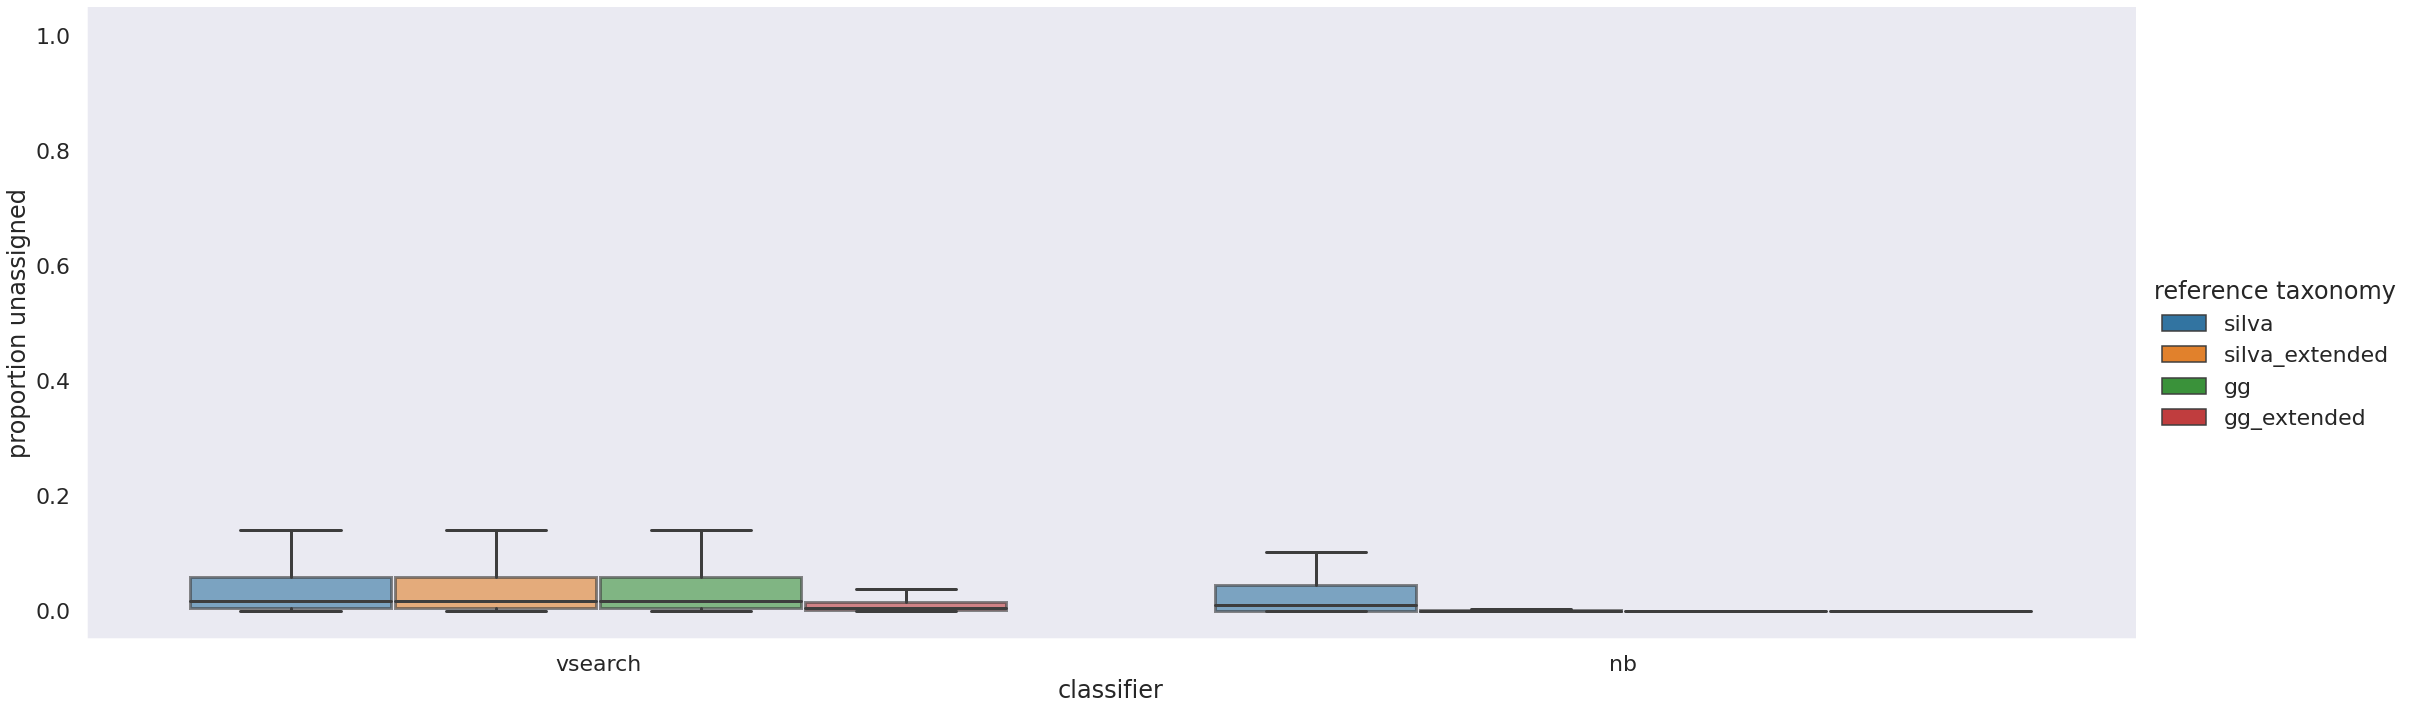

In [55]:
g = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3, kind = 'box', fliersize = 0,
                x='classifier', y = 'proportion unassigned', hue = 'reference taxonomy', data = results[results['denoiser'] == 'dada2'])

In [50]:
deblur_df = results[results['denoiser'] == 'dada2']
deblur_df

,absolute unassigned,proportion unassigned,absolute chloroplasts,proportion chloroplasts,absolute mitochondria,proportion mitochondria,denoiser,classifier,reference taxonomy
#SampleID,,,,,,,,,
12366.1985,19.0,0.003278,0.0,0.000000,0,0.0,deblur,vsearch,silva
12366.1986,25.0,0.009168,2.0,0.000733,0,0.0,deblur,vsearch,silva
12366.1989,145.0,0.054044,42.0,0.015654,0,0.0,deblur,vsearch,silva
12366.1990,27.0,0.036437,8.0,0.010796,0,0.0,deblur,vsearch,silva
12366.1993,10.0,0.013624,0.0,0.000000,0,0.0,deblur,vsearch,silva
...,...,...,...,...,...,...,...,...,...
12366.2198,0,0,0.0,0.000000,0,0.0,deblur,nb,gg_extended
12366.2201,0,0,0.0,0.000000,0,0.0,deblur,nb,gg_extended
12366.2202,0,0,0.0,0.000000,0,0.0,deblur,nb,gg_extended


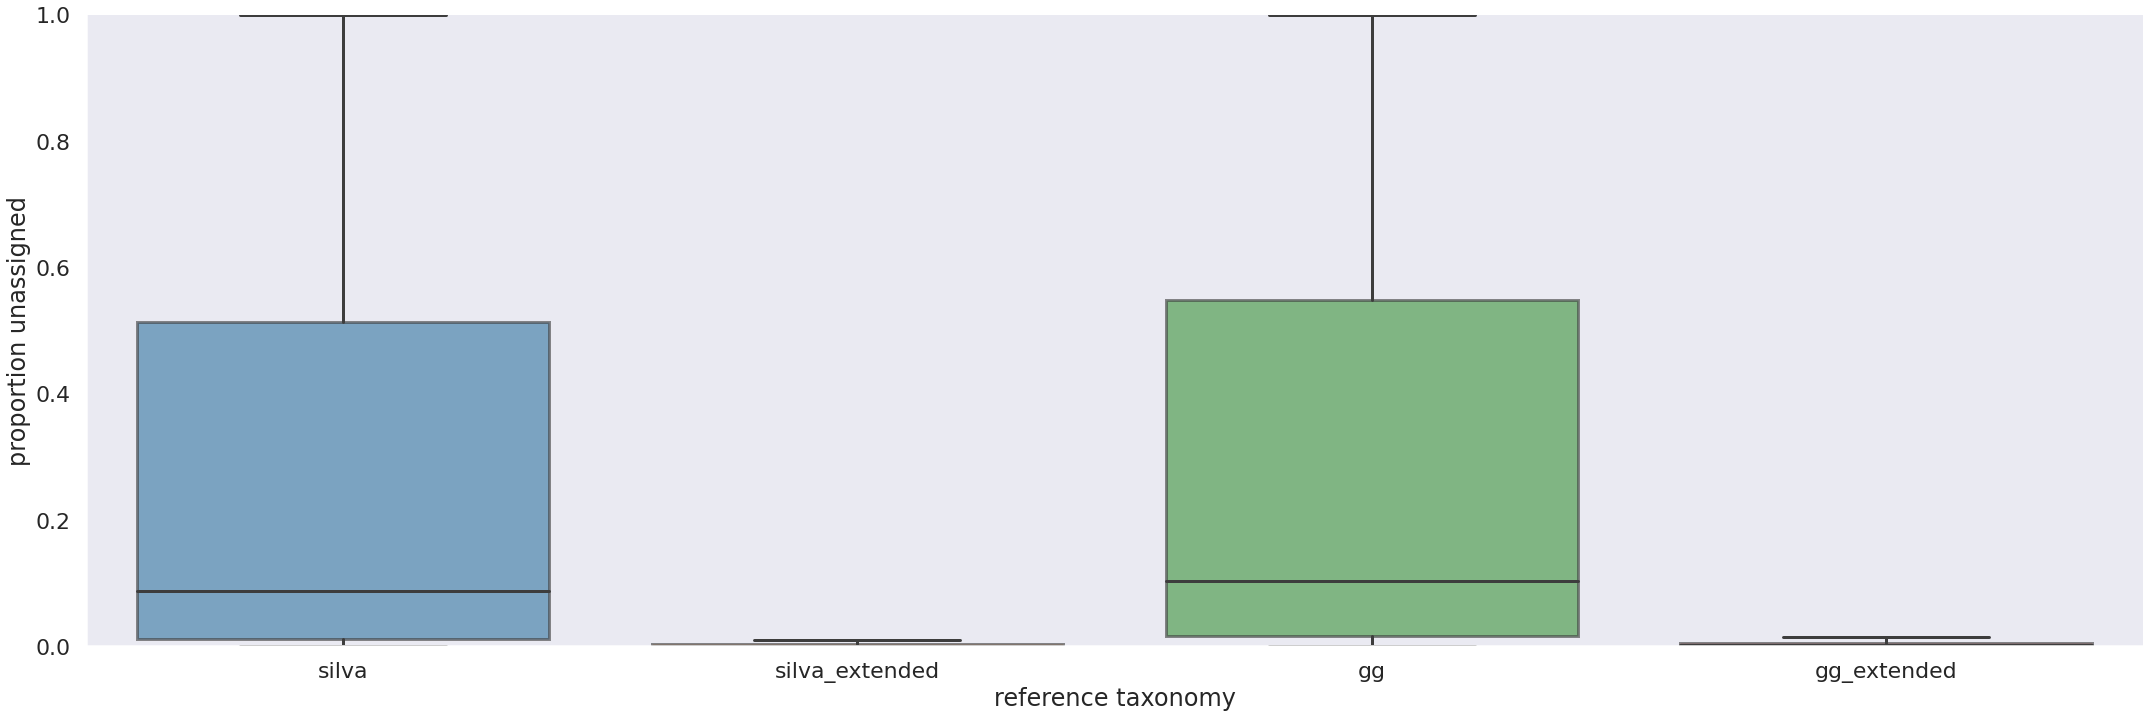

In [11]:
g = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion unassigned",
                kind = "box", data = df, fliersize = 0)
#h = sns.swarmplot(x = "reference taxonomy", dodge = True,
#                   y = "proportion unassigned",
#                   size = 3, data = df, ax = g.ax, palette = "dark")
g.set(ylim=(0, 1))

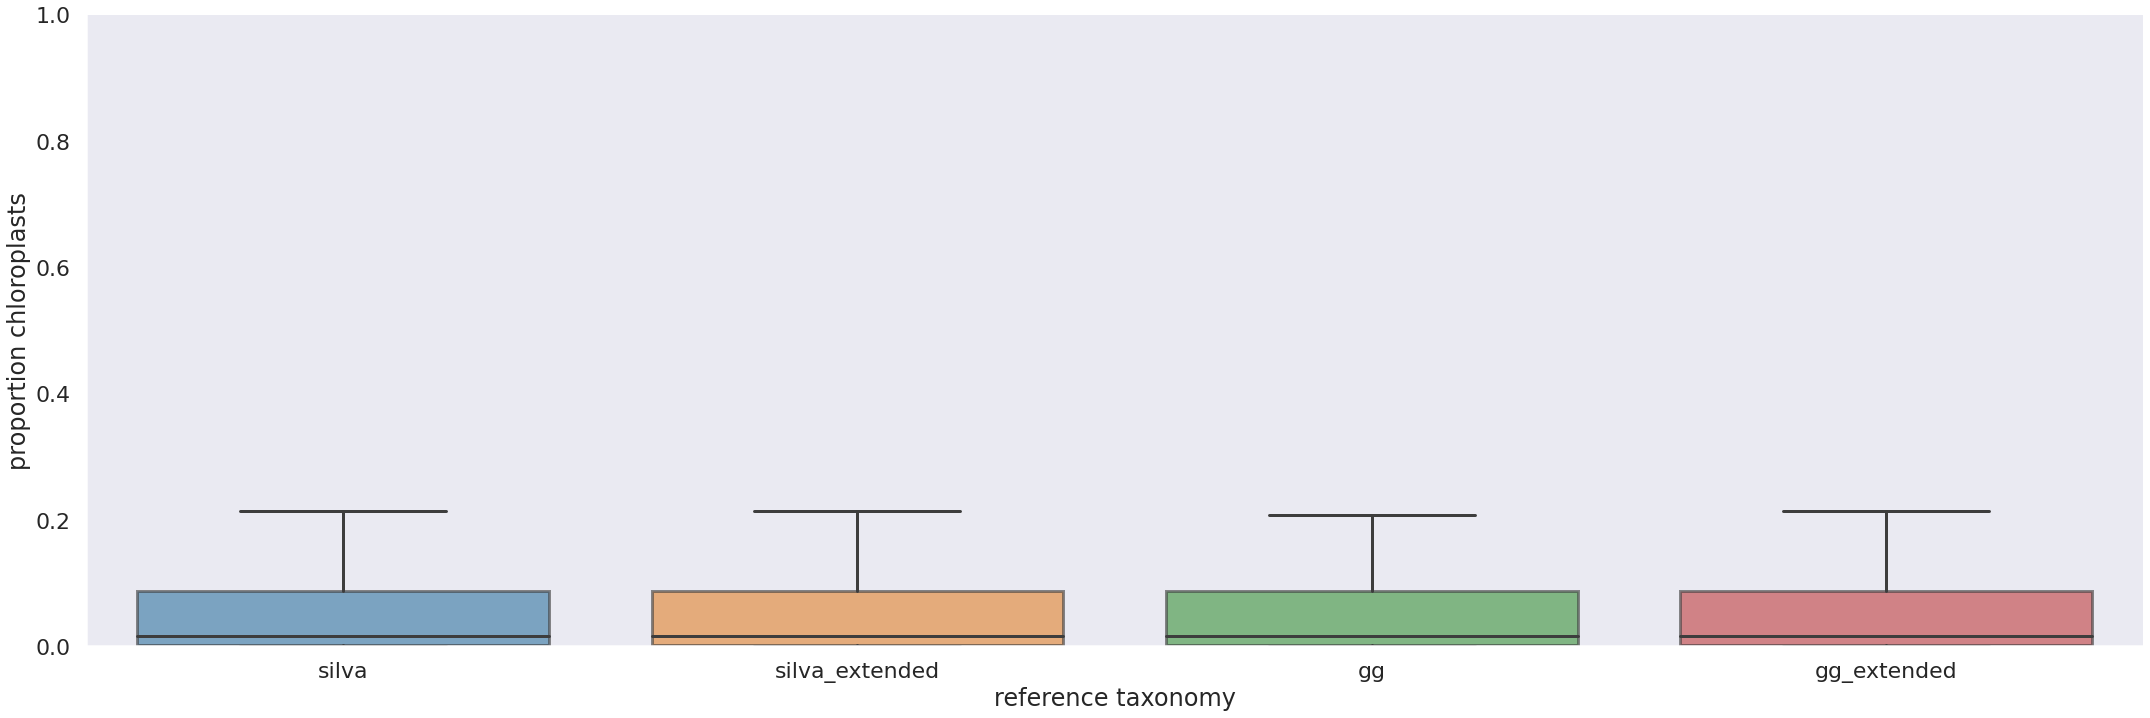

In [12]:
i = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion chloroplasts",
                kind = "box", data = df, fliersize = 0)
# j = sns.swarmplot(x = "reference taxonomy", dodge = True,
#                   y = "proportion chloroplasts",
#                   size = 3, data = df, ax = i.ax, palette = "dark")
i.set(ylim=(0, 1))

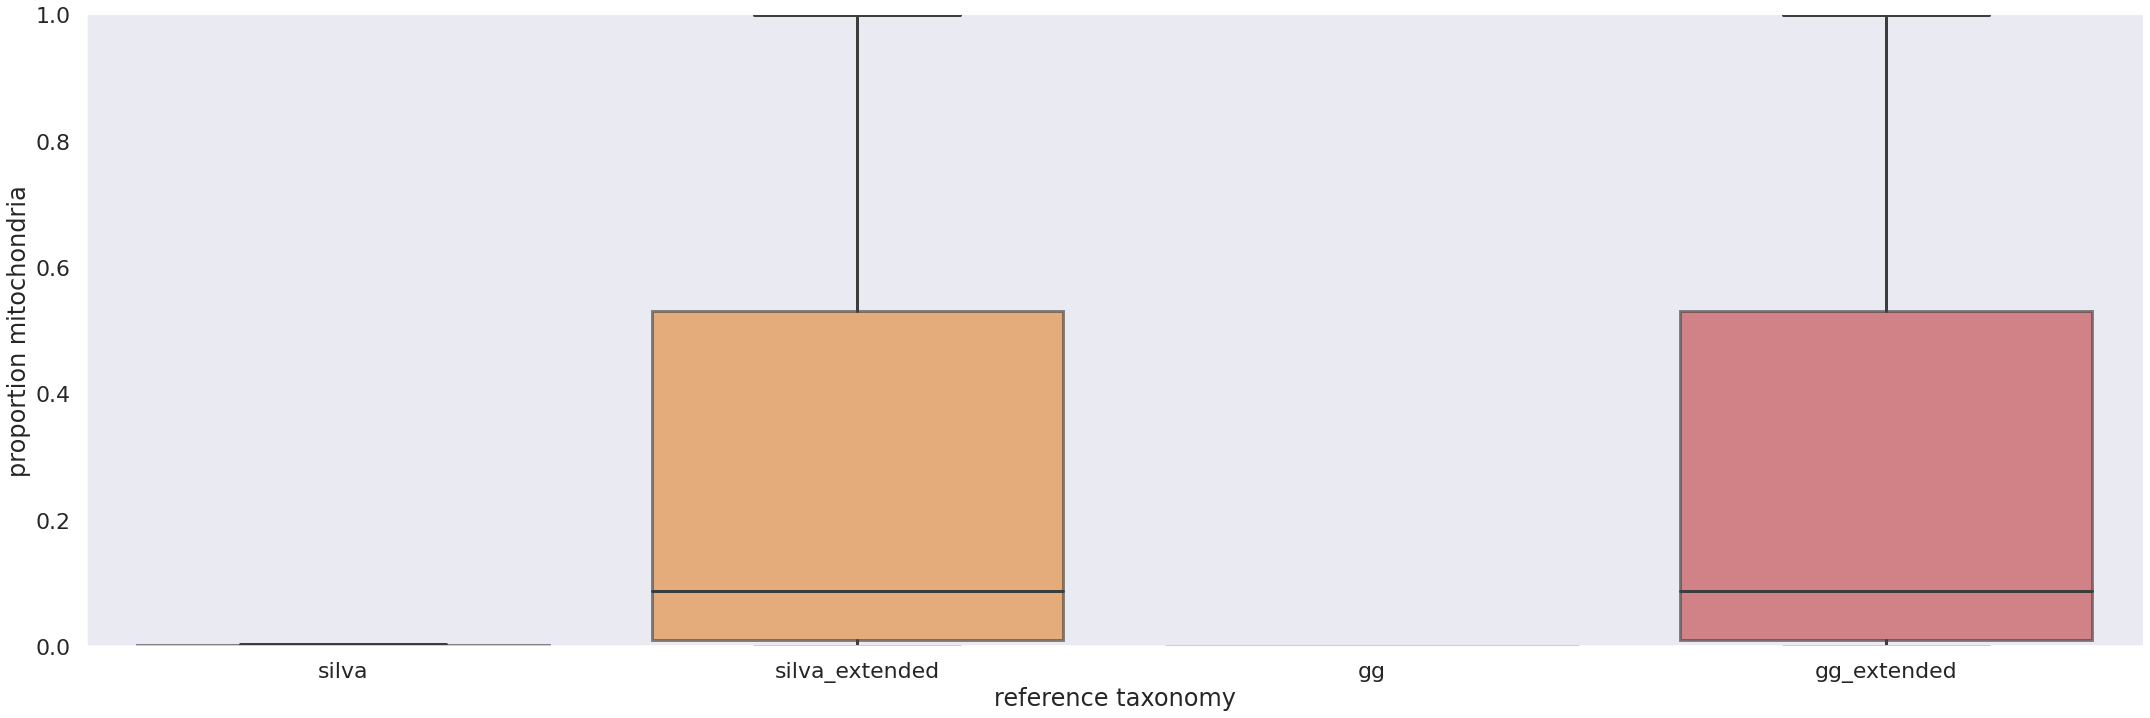

In [13]:
k = sns.catplot(boxprops = dict(alpha = .6), height = 10, aspect = 3,
                x = "reference taxonomy", y = "proportion mitochondria",
                kind = "box", data = df, fliersize = 0)
# l = sns.swarmplot(x = "reference taxonomy", dodge = True,
#                   y = "proportion mitochondria",
#                   size = 3, data = df, ax = k.ax, palette = "dark")
k.set(ylim=(0, 1))

In [14]:
#find differentially annotated sequences
for base_reference in ['silva', 'gg']:
    base_classification = Artifact.load(working_dir + '/output/' + base_reference +
                                   '_classification_taxonomy1.qza')
    extended_classification = Artifact.load(working_dir +
                                            '/output/' + base_reference +
                                            '_extended_classification_taxonomy1.qza')
    with tempfile.TemporaryDirectory() as temp_dir:
        base_classification.export_data(temp_dir)
        base_taxonomy = pd.read_csv(temp_dir + '/taxonomy.tsv', '\t')
        extended_classification.export_data(temp_dir)
        extended_taxonomy = pd.read_csv(temp_dir + '/taxonomy.tsv', '\t')
    base_taxonomy = base_taxonomy.sort_values('Feature ID')
    base_taxonomy = base_taxonomy.reset_index()
    base_taxonomy = base_taxonomy.drop(['Consensus','index'],1)
    extended_taxonomy = extended_taxonomy.sort_values('Feature ID')
    extended_taxonomy = extended_taxonomy.reset_index()
    extended_taxonomy = extended_taxonomy.drop(['Consensus','index'],1)
    results = base_taxonomy.compare(extended_taxonomy)
    results.columns = [base_reference, 'extended']
    results['sequence'] = base_taxonomy['Feature ID']
    with open(working_dir + '/output/' + base_reference + '_differential_annotations1.fasta', 'w') as fasta_file:
        for row in results.itertuples(False, None):
            fasta_file.write('>' + row[0] + '|' + row[1] + '\n' + row[2] + '\n')
    with open(working_dir + '/output/' + base_reference + '_differential_annotations1.tsv', 'w') as tsv:
        tsv.write('sequence\t' + base_reference + '_annotation\textended_annotation\n')
        for row in results.itertuples(False, None):
            tsv.write(row[2] + '\t' + row[0] + '\t' + row[1] + '\n')

In [14]:
#generate featureids to search in qiita (feature ids == sequences in this case)
for base_reference in ['silva', 'gg']:
    with open(working_dir + '/output/' + base_reference + '_differential_annotations.tsv') as infile:
        with open(working_dir + '/output/' + base_reference + '_differential_features.txt', 'w') as outfile:
            for line in infile:
                feature = line.split('\t', 1)[0]
                outfile.write(feature + '\n')

In [15]:
!redbiom search features --from ../output/gg_differential_features.txt --context Pick_closed-reference_OTUs-Greengenes-Illumina-16S-V4-100nt-a243a1 > $(working_dir + '/output/redbiom_gg_samples.)
with open(working_dir)

SyntaxError: invalid syntax (<ipython-input-15-f1ff2604e0e7>, line 2)

In [ ]:
!redbiom search features --from ../output/silva_differential_features.txt --context Deblur-Illumina-16S-V4-100nt-fbc5b2 > test_silva.txt

In [ ]:
artifacts = []
studies = []

with open(working_dir + '/procedure/test_silva.txt') as sample_info:
    with open(working_dir + '/output/silva_diff_studies.txt', 'w') as study_info:
        for line in sample_info:
            artifact_id_plus_study_id = line.split('.', 1)[0]
            artifacts.append(artifact_id_plus_study_id)
            study_id = artifact_id_plus_study_id.split('_')[1]
            studies.append(study_id)
        artifact_counts = Counter(artifacts)
        study_counts = Counter(studies)

In [ ]:
artifact_counts

In [ ]:
max(artifact_counts, key=artifact_counts.get)

In [ ]:
!redbiom search features --help

In [ ]:
!redbiom search features --from ../output/silva_differential_features.txt --context Deblur-Illumina-16S-V4-100nt-fbc5b2 --min-count 100000 > test_silva.txt

In [ ]:
!redbiom search features --from ../output/silva_differential_features.txt --context Deblur-Illumina-16S-V4-100nt-fbc5b2 --exact > test_silva_exact.txt

In [ ]:
GCMP_compartments.export_data(working_dir + '/output')
!biom convert -i ../output/feature-table.biom -o ../output/feature_table.txt --to-tsv

In [ ]:
df = pd.read_csv(working_dir + '/output/feature_table.txt', '\t', index_col = '#OTU ID', skiprows = 1)
df['total count'] = df.sum(1)
df

In [ ]:
diffs = pd.read_csv(working_dir + '/output/differential_annotations.tsv', '\t', index_col = 'sequence')
diffs

In [ ]:
df = diffs.merge(df, 'left', left_index = True, right_index = True)
df = df.sort_values('total count', 0, False)
df

In [ ]:
df.to_csv(working_dir + '/blast.csv')

In [ ]:
i = 0
with open(working_dir + '/blast.csv', 'r+') as file:
    next(file)
    with open('real_blast.fasta', 'w') as blastfile:
        for line in file:
            while i<999900:
                sequence = line.split(',', 1)[0]
                extended_annotation = line.split(',', 3)[2]
                label = extended_annotation.split(';')[-1]
                i+=len('>' + label + '\n' + sequence + '\n')
                blastfile.write('>' + label + '\n' + sequence + '\n')
                print(i)
                break